In [4]:
import os
import sys
import pickle
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ztffields

from astropy.visualization import simple_norm
from astropy.io import fits
from photutils.psf import EPSFModel

sys.path.append('/Users/adamboesky/Research/long_transients')

from Extracting.utils import img_ab_mag_to_flux, load_ecsv

# Plot formatting
plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed
mpl.rcParams['axes.formatter.use_mathtext'] = True

np.random.seed(22)

/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/ztffields/plotting.py:879: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [Polygon(**fieldvert_.to_dict(), **kwargs) for i, fieldvert_ in fieldverts.iterrows()]


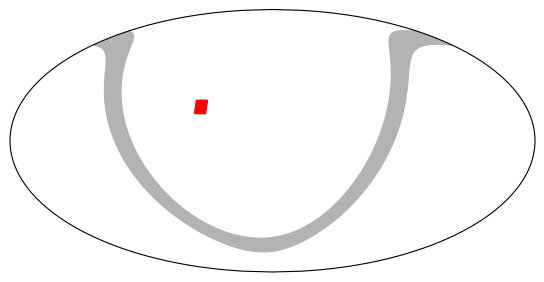

In [17]:
# We will be doing efficiency tests with field 582, ccdid 2, quadrant 1
ztffields.skyplot_fields([582], color='red', alpha=1.0, level='quadrant')
plt.show()

# Demonstrate how to inject sources into images

In [2]:
# Load image
hdul = fits.open('/Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000582_zg_c02_q1_refimg.fits')
img = hdul[0].data.byteswap().newbyteorder()

# Load corresponding EPSF
epsf_data = np.load('/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/EPSFs/ZTF_g_EPSF.npy')
epsf = EPSFModel(data=epsf_data)

        Use `ImagePSF` instead. [warnings]


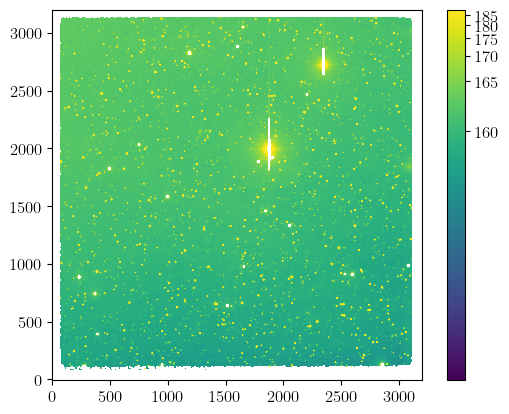

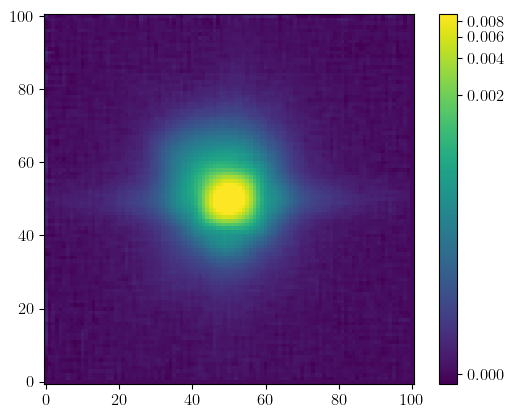

In [3]:
# Plot original image
norm = simple_norm(img, 'log', percent=99.0)
plt.imshow(img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

# Plot epsf
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

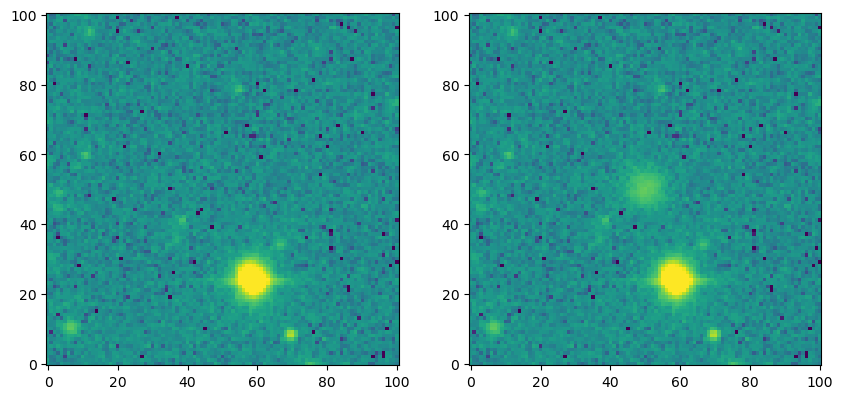

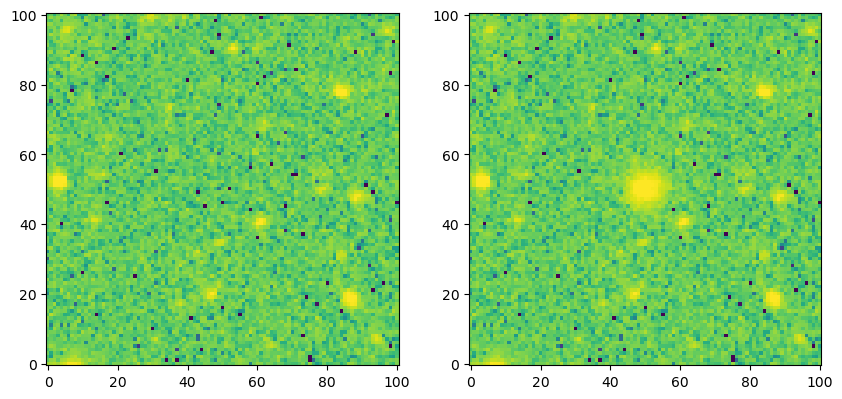

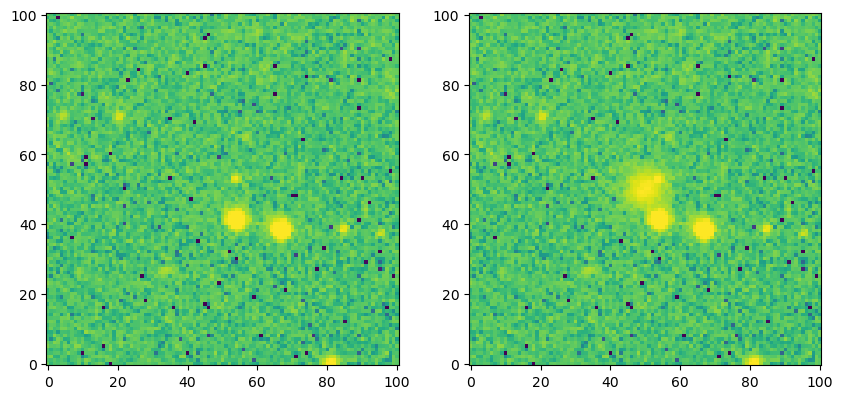

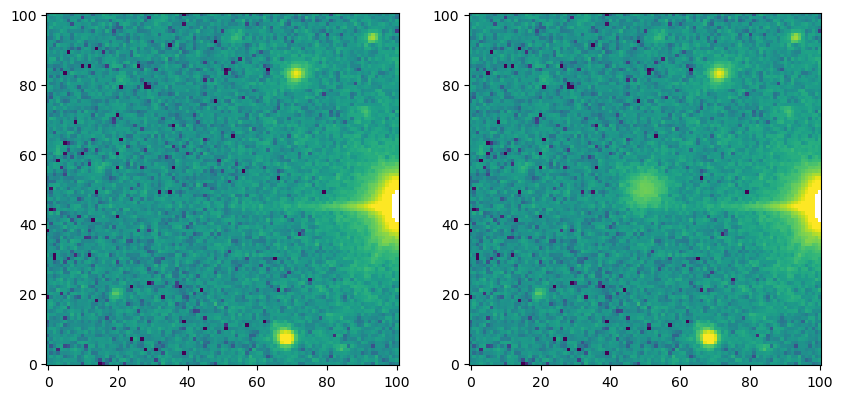

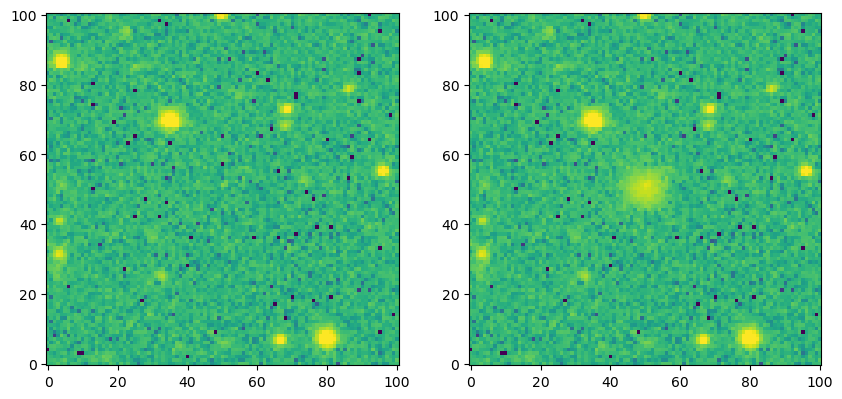

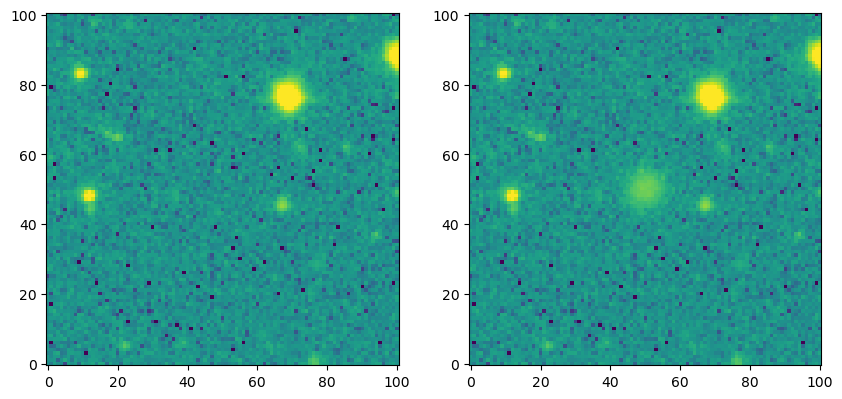

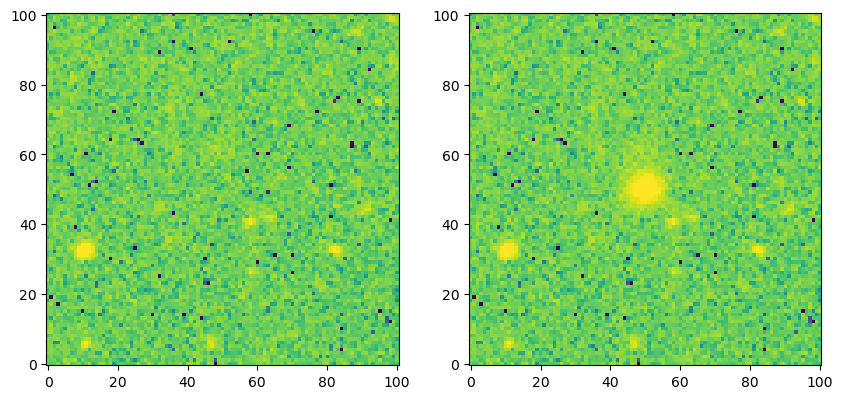

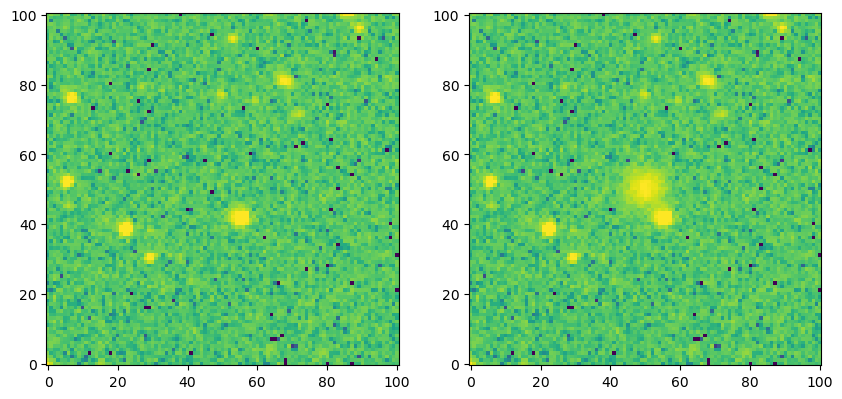

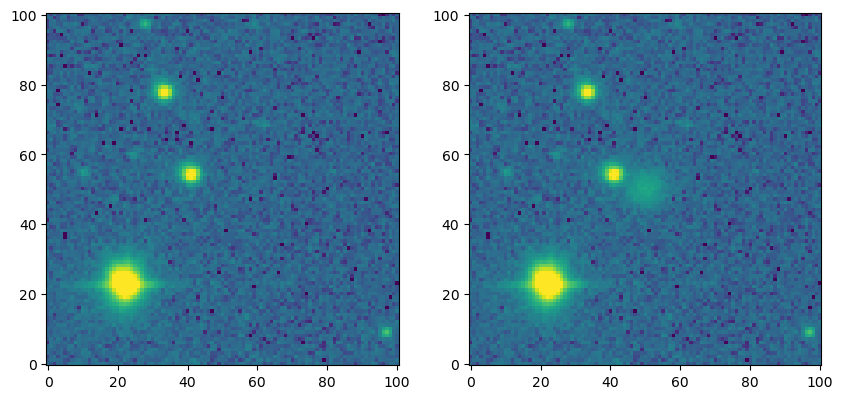

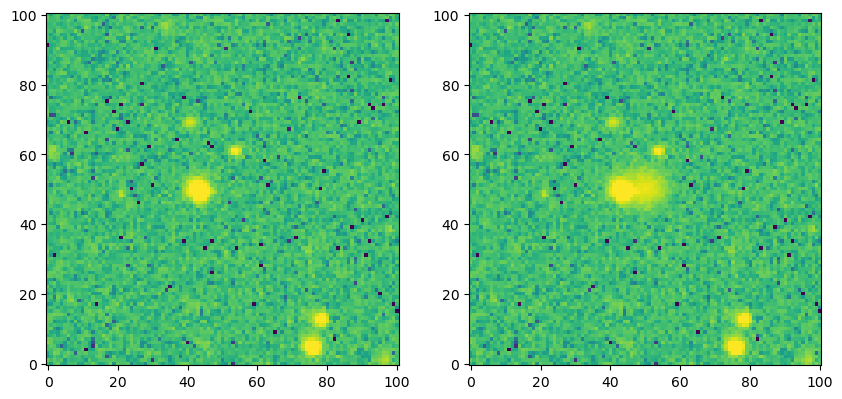

In [20]:
# Inject epsfs in random coordinates
n_injected = 10
psf_half_width = int((epsf.shape[0] - 1) / 2)
xs = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)
ys = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)

# Get flux scaling
mag_injected = 22
total_flux = img_ab_mag_to_flux(mag_injected, zero_point=hdul[0].header['MAGZP'])

# Add PSF at each random coordinate
img_injected = img.copy()
for x, y in zip(xs, ys):
    img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width] += epsf_data * total_flux
    norm = simple_norm(img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width], 'log', percent=99.0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width], norm=norm, origin='lower', cmap='viridis')
    mappable = axes[1].imshow(img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width], norm=norm, origin='lower', cmap='viridis')
    plt.show()

# Inject sources into some fields for testing

In [2]:
injection_dir = '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources'

def inject_into_quadrant(
        field: int,
        ccdid: int,
        quadrant: int,
        band: str,
        n_injected: int = 100,
        injection_mags: np.ndarray = np.arange(16, 25, 1),
    ) -> str:
    # Construct filenames
    img_fpath = f'/Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_{str(field).zfill(6)}_z{band}_c{str(ccdid).zfill(2)}_q{quadrant}_refimg.fits'
    res_dirname = f'{str(field).zfill(6)}_{str(ccdid).zfill(2)}_{quadrant}'
    extraction_dirpath = f'/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/{res_dirname}'
    injection_outdirpath = os.path.join(injection_dir, res_dirname)

    # Load image
    hdul = fits.open(img_fpath)
    img = hdul[0].data.byteswap().newbyteorder()

    # Load corresponding EPSF
    epsf_data = np.load(open(os.path.join(extraction_dirpath, f'EPSFs/ZTF_{band}_EPSF.npy'), 'rb'))
    epsf = EPSFModel(data=epsf_data)

    # Inject epsfs in random coordinates
    psf_half_width = int((epsf.shape[0] - 1) / 2)
    xs = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)
    ys = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)

    # Store the coords
    with open(os.path.join(injection_outdirpath, 'coords.npy'), 'wb') as f:
        np.save(f, np.vstack((xs, ys)).T)

    # Store the original fits file
    fits.writeto(filename=os.path.join(injection_outdirpath, 'orig.fits'), data=img, header=hdul[0].header, overwrite=True)

    outfnames = []
    for mag_injected in injection_mags:
        outfname = os.path.join(injection_outdirpath, f'mag{str(mag_injected).replace('.', '_')}.fits')
        outfnames.append(outfname)

        # Get flux for given mag
        injection_flux = img_ab_mag_to_flux(mag_injected, zero_point=hdul[0].header['MAGZP'])

        # Add PSF at each random coordinate
        img_injected = img.copy()
        for x, y in zip(xs, ys):
            img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width] += epsf_data * injection_flux

        # Store data
        fits.writeto(filename=outfname, data=img_injected, header=hdul[0].header, overwrite=True)

    return outfnames

In [3]:
from astropy.table import Table

t = Table.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000582_g.ecsv')
print(f"Image magnitude limit = {t[(t['fieldid'] == '000582') & (t['ccdid'] == '02') & (t['qid'] == '1')]['ZTF_g_mag_limit'][0]}")

Image magnitude limit = 23.96


In [5]:
# Quadrant data we will inject for
fields = [582]
ccdids = [2]
quadrants = [1]

# Inject and save
for field, ccdid, quadrant in zip(fields, ccdids, quadrants):
    outfiles = inject_into_quadrant(field, ccdid, quadrant, band='g', injection_mags=np.arange(16, 25, 0.5))
    print(f'Saved the following files:\n{outfiles}')

        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

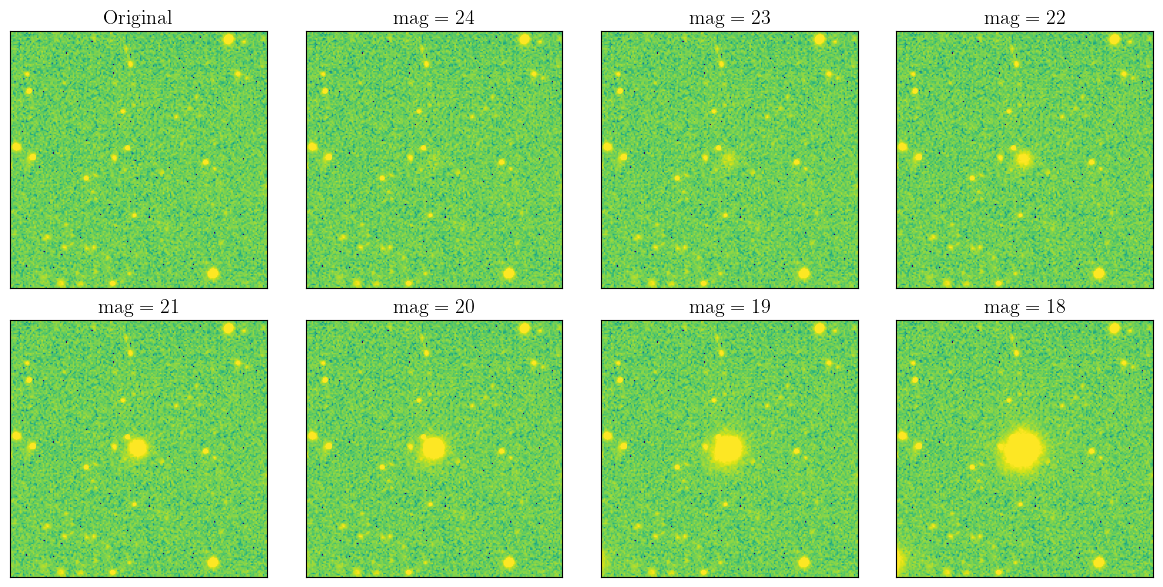

In [13]:
# Confirm outputs look right
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Load some stuff
test_outdir = '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1'
coords = np.load(open(os.path.join(test_outdir, 'coords.npy'), 'rb'))
orig = fits.open(os.path.join(test_outdir, 'orig.fits'))
x, y = tuple(coords[5])

# Get cutout_norm
cutout_halfwidth = 90
cutout = orig[0].data[x - cutout_halfwidth : x + cutout_halfwidth, y - cutout_halfwidth : y + cutout_halfwidth]

# Plot original
norm = simple_norm(cutout, 'log', percent=99.0)
axes[0][0].imshow(cutout, norm=norm)
axes[0][0].set_title('Original')

# Plot one coord in each image
fnames = [f for f in os.listdir(test_outdir) if f[:3] == 'mag']
args = np.argsort([int(f[3:5]) for f in fnames])[::-1]
for ax, fname in zip(axes.flatten()[1:], np.array(fnames)[args]):
    img = fits.open(os.path.join(test_outdir, fname))
    ax.imshow(img[0].data[x - cutout_halfwidth : x + cutout_halfwidth, y - cutout_halfwidth : y + cutout_halfwidth], norm=norm)
    if fname.split('.')[0][:3] == 'mag':
        ax.set_title(rf"$\textrm{{mag}}={fname.split('.')[0][-2:]}$")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/long_transients/Figures/injected_source_examples.pdf', bbox_inches='tight')
plt.show()

# Test Extraction

In [11]:
from Extracting.Source_Extractor import Source_Extractor

# Dict of mags
test_outdir = '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1'
fpaths = {float(f[3:7].replace('_', '.')): os.path.join(test_outdir, f) for f in os.listdir(test_outdir) if f[:3] == 'mag'}
fpaths[-999] = os.path.join(test_outdir, 'orig.fits')
coords = np.load(open(os.path.join(test_outdir, 'coords.npy'), 'rb'))

# Load source extractors
sextractors = {mag: Source_Extractor(fpath, 'g') for mag, fpath in fpaths.items()}
print(sextractors)

{22.5: <Extracting.Source_Extractor.Source_Extractor object at 0x2ca06f0e0>, 17.0: <Extracting.Source_Extractor.Source_Extractor object at 0x15c8c8c20>, 18.5: <Extracting.Source_Extractor.Source_Extractor object at 0x2ca070c80>, 21.0: <Extracting.Source_Extractor.Source_Extractor object at 0x15c52b5c0>, 19.0: <Extracting.Source_Extractor.Source_Extractor object at 0x2ca0170b0>, 20.5: <Extracting.Source_Extractor.Source_Extractor object at 0x15bd56ea0>, 16.5: <Extracting.Source_Extractor.Source_Extractor object at 0x2ca0769f0>, 23.0: <Extracting.Source_Extractor.Source_Extractor object at 0x17e6ff380>, 24.5: <Extracting.Source_Extractor.Source_Extractor object at 0x17e6fcdd0>, 19.5: <Extracting.Source_Extractor.Source_Extractor object at 0x2ca07a750>, 20.0: <Extracting.Source_Extractor.Source_Extractor object at 0x17e6f9520>, 16.0: <Extracting.Source_Extractor.Source_Extractor object at 0x2ca0771d0>, 23.5: <Extracting.Source_Extractor.Source_Extractor object at 0x2ca073620>, 22.0: <Extr

In [37]:
# Get the results
extraction_results = {}
for mag, sextractor in sextractors.items():
    extraction_results[mag] = sextractor.get_data_table(include_psf=False, include_kron=True)

Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


In [44]:
n_retrieved = {}
for mag, res in extraction_results.items():
    n_retrieved[mag] = 0
    for coord in coords:
        if np.any((np.abs(res['y'] - coord[0] + 1) < 1) & (np.abs(res['x'] - coord[1] + 1) < 1)):
            n_retrieved[mag] += 1

for mag in np.sort(list(n_retrieved.keys())):
    print(f'{mag}: {n_retrieved[mag]}')

-999: 2
16: 96
17: 96
18: 95
19: 95
20: 95
21: 95
22: 91
23: 85
24: 57


# Test Extraction 100 times to get variance

In [24]:
def extract():
    # Quadrant data we will inject for
    fields = [582]
    ccdids = [2]
    quadrants = [1]

    # Inject and save
    for field, ccdid, quadrant in zip(fields, ccdids, quadrants):
        outfiles = inject_into_quadrant(field, ccdid, quadrant, band='g', injection_mags=np.arange(16, 25, 0.5))
        print(f'Saved the following files:\n{outfiles}')

    # Dict of mags
    fpaths = {float(f[3:7].replace('_', '.')): os.path.join(test_outdir, f) for f in os.listdir(test_outdir) if f[:3] == 'mag'}
    fpaths[-999] = os.path.join(test_outdir, 'orig.fits')
    coords = np.load(open(os.path.join(test_outdir, 'coords.npy'), 'rb'))

    # Load source extractors
    sextractors = {mag: Source_Extractor(fpath, 'g') for mag, fpath in fpaths.items()}
    # Get the results
    extraction_results = {}
    for mag, sextractor in sextractors.items():
        extraction_results[mag] = sextractor.get_data_table(include_psf=False, include_kron=True)
    n_retrieved = {}
    for mag, res in extraction_results.items():
        n_retrieved[mag] = 0
        for coord in coords:
            if np.any((np.abs(res['y'] - coord[0] + 1) < 1) & (np.abs(res['x'] - coord[1] + 1) < 1)):
                n_retrieved[mag] += 1

    return n_retrieved

In [25]:
n_retrieved = {}
for i in range(25):
    if i % 5 == 0:
        print(f'Iteration {i} / 25')
    n_retrieved_it = extract()
    for k in n_retrieved_it.keys():
        if k not in n_retrieved:
            n_retrieved[k] = []
        n_retrieved[k].append(n_retrieved_it[k])

Iteration 0 / 25


        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Iteration 5 / 25


        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Iteration 10 / 25


        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
/Users/adamboesky/Research/long_transients/Extracting/utils.py:38: RuntimeWarning: divide by zero encountered in divide
  magerr = 2.5 * fluxerr / (np.log(10) * flux)


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Iteration 15 / 25


        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Iteration 20 / 25


        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
        Use `ImagePSF` instead. [warnings]


Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag16_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag17_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag18_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag19_5.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000582_02_1/mag20_0.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_d

/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


In [26]:
for mag in np.sort(list(n_retrieved.keys())):
    print(f'{mag}: {np.mean(n_retrieved[mag])} +/- {np.std(n_retrieved[mag]):.2f}')

-999.0: 0.64 +/- 0.79
16.0: 97.12 +/- 1.53
16.5: 97.16 +/- 1.49
17.0: 97.0 +/- 1.60
17.5: 97.04 +/- 1.64
18.0: 96.68 +/- 1.76
18.5: 96.56 +/- 1.81
19.0: 96.28 +/- 1.78
19.5: 95.6 +/- 1.92
20.0: 95.2 +/- 1.85
20.5: 94.72 +/- 1.95
21.0: 93.8 +/- 1.92
21.5: 93.16 +/- 1.83
22.0: 91.32 +/- 2.31
22.5: 88.88 +/- 2.90
23.0: 85.44 +/- 3.58
23.5: 76.72 +/- 4.97
24.0: 51.16 +/- 4.66
24.5: 26.56 +/- 5.60


In [27]:
with open('/Users/adamboesky/Research/long_transients/Data/n_retrieved.pkl', 'wb') as f:
    pickle.dump(n_retrieved, f)

In [14]:
with open('/Users/adamboesky/Research/long_transients/Data/n_retrieved.pkl', 'rb') as f:
    n_retrieved = pickle.load(f)

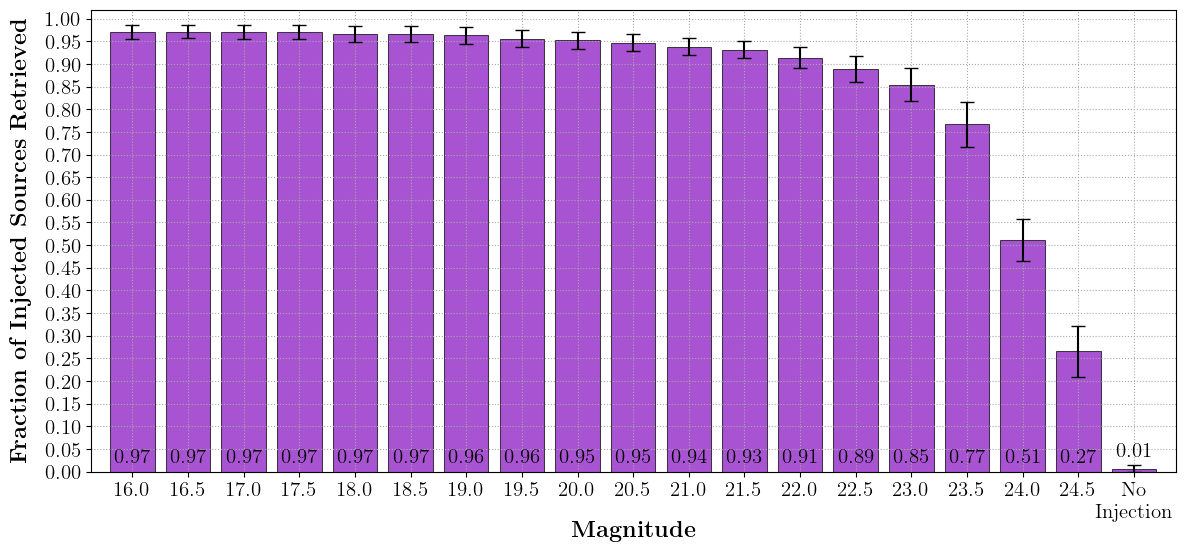

In [53]:
# Extract data for plotting
mags = np.sort(list(n_retrieved.keys()))
mags = list(mags[1:]) + [mags[0]]
means = [np.mean(n_retrieved[mag]) for mag in mags]
stds = [np.std(n_retrieved[mag]) for mag in mags]
mag_strs = [str(mag) for mag in mags]
mag_strs[-1] = 'No\nInjection'

# Create the bar plot
plt.figure(figsize=(14, 6))
bars = plt.bar(mag_strs, np.array(means) / 100, yerr=np.array(stds) / 100, capsize=5, alpha=0.7, color='#840bbf', edgecolor='black', linewidth=0.75)

# Annotate the bars with actual values
for bar, mean in zip(bars, means):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 0.01 if mean > 10 else 0.025, f'{mean/100:.2f}', ha='center', va='bottom', fontsize=15)

plt.xlabel(r'\bf{Magnitude}', fontsize=17, labelpad=0)
plt.ylabel(r'\bf{Fraction of Injected Sources Retrieved}', fontsize=17, labelpad=10)

plt.yticks(np.arange(0, 1.01, 0.05))
plt.xlim(-0.75, len(mags) - 0.25)
plt.ylim(0, 1.02)
plt.grid(True, ls=':', color='darkgray')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/injection_efficiency.pdf', bbox_inches='tight')
plt.show()